# Hidden Markov Models

For users already familiar with the interface, the [API docs](../api/index_markov.rst#sktime-markov-hmm).

Hidden markov models (HMM) are a type of markov model where the underlying markov process $X_t$ is _hidden_ and there is an _observable_ process $Y_t$ which depends on $X_t$. When fitting such a model, the goal is to parameterize a markov model over $X_t$ by observing $Y_t$. Here the dependency of $Y_t$ on $X_t$ must be immediate, i.e.,

$$ \mathbb{P}(Y_t \in A \mid X_1 = x_1, \ldots, X_n = x_n) = \mathbb{P}(Y_t \in A \mid X_n = x_n). $$

The states of process $X_i$ are often called "hidden states" or "macro states", whereas $\mathbb{P}(Y_t\in A \mid X_n = x_n)$ is referred to as output probability or emission probability.

In particular that means that - opposed to ordinary [markov state models](mlmsm.ipynb), here one hidden state maps to a probability distribution over the observable space in which $Y_t$ takes its values.

Due to its higher-order nature, it can recover from situations and produce good results when MSMs would not, for example in some cases of bad state space discretization. However, HMMs are harder to fit, computationally more expensive, and the estimation likes to get stuck in local optima.

In scikit-time, a hidden markov model is determined by

- a hidden transition model $P\in\mathbb{R}^{n\times n}$ (of type [MarkovStateModel](../api/generated/sktime.markov.msm.MarkovStateModel.rst#sktime.markov.msm.MarkovStateModel)) describing the hidden process,
- an [output model](../api/generated/sktime.markov.hmm.OutputModel.rst#sktime.markov.hmm.OutputModel), which holds information on the emission probabilities,
- and an initial distribution $\pi\in\mathbb{R}^n$ over the hidden states, which expresses a prior belief over the average most likely distribution of hidden states.

Creating an [HMM](../api/generated/sktime.markov.hmm.HiddenMarkovStateModel.rst#sktime.markov.hmm.HiddenMarkovStateModel) is as simple as importing sktime and fixing at least the transition model and the output model.

Here $P\in\mathbb{R}^{2\times 2}$ is the hidden transition matrix and $E\in\mathbb{R}^{2\times 3}$ are the emission probabilities mapping from two hidden states to two three-state output probability distributions:

In [1]:
import numpy as np
import sktime
import sktime.markov.hmm as hmm

P = np.array([[0.95, 0.05], [0.3, 0.7]])
E = np.array([
    [0.1, 0.1, 0.8], [0.5, 0.5, 0.]
])

ground_truth = hmm.HiddenMarkovStateModel(P, E)

This hidden markov model has two hidden (macro) states and three output (micro) states. The initial distribution defaults to a uniform distribution, which prefers no hidden state over the other.

In [2]:
print("# hidden states:", ground_truth.n_hidden_states)
print("# observation states:", ground_truth.n_observation_states)

# hidden states: 2
# observation states: 3


We can now generate an hidden and corresponding observation sequence from the hmm:

In [3]:
(hidden_trajectory, observation_trajectory) = ground_truth.simulate(2000)

Visualizing the hidden trajectory, one can observe that state 0 is preferred. The observation trajectory jumps between three states. If the hidden state is $0$, the observation trajectory is most of the time in micro state $2$, otherwise it is in state $0$ or $1$:

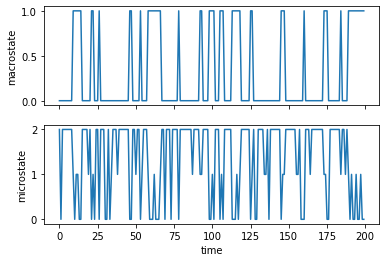

In [4]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(hidden_trajectory[:200])
ax1.set_ylabel("macrostate")
ax2.plot(observation_trajectory[:200])
ax2.set_xlabel("time")
ax2.set_ylabel("microstate");

While the output probabilities in this case map to discrete values, this is not the only option. We implement

- the [discrete output model](../api/generated/sktime.markov.hmm.DiscreteOutputModel.rst#sktime.markov.hmm.DiscreteOutputModel), which maps to a discrete observable space and is parameterized by a row-stochastic output probability matrix $E\in\mathbb{R}^{n\times m}$, where $n$ is the number hidden and $m$ the number of observable states,
- and the [gaussian output model](../api/generated/sktime.markov.hmm.GaussianOutputModel.rst#sktime.markov.hmm.GaussianOutputModel), which maps to a one-dimensional output space with $m$ Gaussians, each parameterized by mean and standard deviation.

## Estimation

The estimation of an HMM given sequences of observations can be performed using the Baum-Welch algorithm <cite data-cite="nbhmm-baum1967inequality">(Baum, 1967)</cite>, which belongs to the family of expectation-maximization algorithms.

It crucially requires an initial guess for emission probabilities and hidden state transition matrix, as the optimization is prone to getting stuck in local optima. After optimization, the likelihood for a trained model is available and can be compared to models with different initial guesses.

Going back to above example, we can try to fit a HMM based on the observation trajectory for different initial guesses:

In [5]:
hmm_est_real = hmm.MaximumLikelihoodHMSM(
    initial_model=ground_truth
).fit(observation_trajectory).fetch_model()

In [6]:
print("Maximum absolute deviation: {:.3f}".format(
    np.max(np.abs(hmm_est_real.transition_model.transition_matrix - P))
))

Maximum absolute deviation: 0.009


When initialized with the ground truth, the deviation is not large from the initial model. Scikit-time furthermore offers some initialization heuristics should the ground truth be unknown.

For discrete output models:

1. [init.discrete.metastable_from_data](../api/generated/sktime.markov.hmm.init.discrete.metastable_from_data.rst#sktime.markov.hmm.init.discrete.metastable_from_data) or [init.discrete.metastable_from_msm](../api/generated/sktime.markov.hmm.init.discrete.metastable_from_msm.rst#sktime.markov.hmm.init.discrete.metastable_from_msm): A reversible [MSM](mlmsm.ipynb) is estimated from given discrete trajectories. This is optional in case the MSM is already available. Then, the estimated transition matrix $P\in\mathbb{R}^{n\times n}$ is coarse-grained with PCCA+ <cite data-cite="nbhmm-roblitz2013fuzzy">(Röblitz, 2013)</cite>, yielding $m$ hidden states and a membership matrix $M\in\mathbb{R}^{n\times m}$. The transition matrix is projected into hidden space via
    $$ P_\mathrm{coarse} = (M^\top M)^{-1}M^\top PM. $$
    This procedure is described in greater detail in <cite data-cite="nbhmm-noe2013projected">(Noé, 2013)</cite>.
2. [init.discrete.random](../api/generated/sktime.markov.hmm.init.discrete.random.rst#sktime.markov.hmm.init.discrete.random): Initializes hidden transition matrix and initial distribution uniformly, the emission probabilities are drawn from $\mathcal{U}(0, 1)$ and normalized to form a row-stochastic matrix.

Let's create a random initial model and use it as starting point for the maximum-likelihood estimation.

In [7]:
init_hmm_random = hmm.init.discrete.random(n_observation_states=3, n_hidden_states=2)
hmm_est_random = hmm.MaximumLikelihoodHMSM(
    initial_model=init_hmm_random
).fit(observation_trajectory).fetch_model()

Also here, we get close to the ground truth hidden transition matrix:

In [8]:
print("Maximum absolute deviation: {:.3f}".format(
    np.max(np.abs(hmm_est_random.transition_model.transition_matrix - P))
))

Maximum absolute deviation: 0.010


## Bayesian sampling